In [1]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, Team, DriverTeamSession, TeamCircuitStats, PitStop
from utils import setup_race_data

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 


## 1) Query race into df and pre process

In [2]:
def get_race_df(year, circuit):
	race_session = (db_session.query(Session)
				.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
				.join(Circuit, RacingWeekend.circuit_id == Circuit.circuit_id)
				.filter(
					RacingWeekend.year == year,
					Circuit.circuit_name == circuit,
					Session.session_type == "Race"
				)
				.first())
	
	laps = race_session.laps

	session_results = (
		db_session.query(SessionResult.position, Driver.driver_num)
		.join(Session, Session.session_id == SessionResult.session_id)
		.join(Driver, Driver.driver_id == SessionResult.driver_id)
		.filter(SessionResult.session_id == race_session.session_id)
		.all()
	)

	# Convert session results to a dictionary
	starting_positions = {driver_num: position for position, driver_num in session_results}

	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		# Add a row for Sector 1
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 1,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s1_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 2
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 2,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s2_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 3
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 3,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s3_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

	# Create a DataFrame from the list of dictionaries
	df = pd.DataFrame(laps_data)
	
	df["starting_position"] = None  # Initialize column with None
	for driver_num, grid_pos in starting_positions.items():
		# Find the first occurrence of the driver
		first_row_index = df[df["driver_number"] == driver_num].index[0]
		df.at[first_row_index, "starting_position"] = grid_pos

	df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	return df


def add_race_data(df):
	# Calculate cumulative race time for each driver
	df["cumulative_time"] = df.groupby("driver_name")["sector_time"].cumsum()
 
	# Calculate rolling pace (average lap time over the last 5 laps)
	df["pace"] = (
		df.groupby(["driver_name", "sector"])["sector_time"]
		.rolling(window=5, min_periods=1)
		.mean()
		.reset_index(level=[0, 1], drop=True)
	)

	# Get car ahead"s cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby(["lap_num", "sector"])["cumulative_time"].shift(1)
	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# Calculate tyre difference (compared to car immediately ahead in THIS Sector)
	df["front_tyre"] = df.groupby(["lap_num", "sector"])["tyre_type"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre_type"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# Calculate tyre age difference (compared to car immediately ahead in THIS Sector)
	df["front_laps"] = df.groupby(["lap_num", "sector"])["stint_lap"].shift(1)
	df["stint_laps_diff"] = df["front_laps"] - df["stint_lap"]
	df["stint_laps_diff"] = df["stint_laps_diff"].fillna(0)  # Leader has no car ahead

	# Calculate DRS availability (within 1s of car ahead IN THIS Sector)
	df["drs_available"] = (
		(df["gap"] <= 1) &
		(df["position"] > 1) &
		(df["lap_num"] > 1)
	)

	# Create target variable for overtaking model (done where its 1 if the driver got overtaken (improved accuracy))
	df["next_position"] = df.groupby("driver_name")["position"].shift(1) 
	df["overtaken"] = ((df["next_position"] < df["position"]) | 
					  (df["next_position"].isna()))
	

	# Cleanup and final sorting
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "next_position"])
	# df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	try:
		new_order = [
			"lap_num", "sector", "stint_num", "stint_lap", "position", "driver_name",
			"driver_number", "sector_time", "gap", "cumulative_time", "tyre_type", "tyre_laps", 
			"pit", "drs_available", "overtaken", "tyre_diff", "front_laps", "stint_laps_diff", "track_status", "pace", "starting_position"
		]

		df = df[new_order]
	except:
		print("dont care")
	return df


df = get_race_df(2023, "Miami")
df = add_race_data(df)

# df[df["sector_time"].isna()]
# df[df["driver_name"]=="Logan Sargeant"]
df.head(5)

,lap_num,sector,stint_num,stint_lap,position,driver_name,driver_number,sector_time,gap,cumulative_time,tyre_type,tyre_laps,pit,drs_available,overtaken,tyre_diff,front_laps,stint_laps_diff,track_status,pace,starting_position
0,1,1,1,1,1,Sergio Perez,11,NaN,0.0,NaN,2,1,False,False,True,0.0,NaN,0.0,1,NaN,2
1,1,1,1,1,2,Fernando Alonso,14,NaN,0.0,NaN,2,2,False,False,True,0.0,1.0,0.0,1,NaN,3
2,1,1,1,1,3,Carlos Sainz,55,NaN,0.0,NaN,2,1,False,False,True,0.0,1.0,0.0,1,NaN,5
3,1,1,1,1,4,Pierre Gasly,10,NaN,0.0,NaN,2,1,False,False,True,0.0,1.0,0.0,1,NaN,8
4,1,1,1,1,5,George Russell,63,NaN,0.0,NaN,2,1,False,False,True,0.0,1.0,0.0,1,NaN,4


### Now create overtaking model

In [3]:
race_data = setup_race_data(df)




{np.int64(2): {np.int64(1): [0.0033783960789112505, -0.09127442263350483, 0.8245490134961793], np.int64(2): [0.0014796680967454033, -0.009165791619970273, 0.18996281850138236], np.int64(3): [0.0015584790139513485, -0.03502050739296145, 0.3313397800799605]}, np.int64(3): {np.int64(1): [-1.53662854434302e-10, 0.005213793497974838, 0.31850945346651255], np.int64(2): [-7.596613994555569e-11, 0.017284317548289935, 0.44974171130775975], np.int64(3): [0.00021413500179193483, 0.004824464247898694, 0.09055538220407366]}, 1: {np.int64(1): [0.2937507053403217, -2.067535206837615, 3.610233724307989], np.int64(2): [0.26749230818922426, -1.809681347179049, 3.072324926854997], np.int64(3): [1.5016601993302848e-17, -0.2652015315675979, 0.9104554355519561]}}


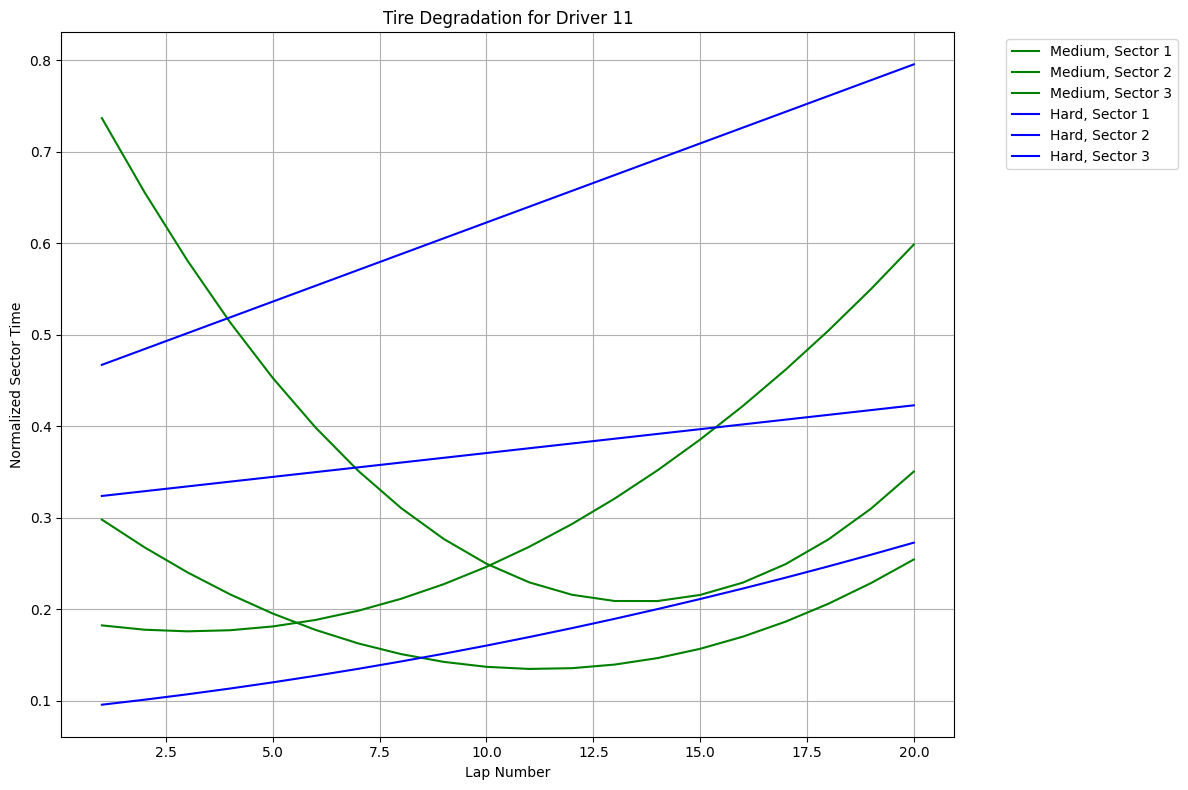

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_tyre_degradation_for_driver(driver_tyre_coefficients, driver_key, max_laps=20):
    """
    Plots the tire degradation curves for a specific driver.
    
    Parameters:
        driver_tyre_coefficients (dict): Dictionary containing tire degradation coefficients for each driver.
                                         Structure: {driver_number: {tyre_type: {sector: [a, b, c]}}}
        driver_key (int): The driver number (key) for which to plot the tire degradation.
        max_laps (int): Maximum number of laps to plot for visualization.
    """
    # Check if the driver exists in the dictionary
    if driver_key not in driver_tyre_coefficients:
        print(f"Driver {driver_key} not found in the data.")
        return
    
    # Get the coefficients for the specified driver
    driver_coeffs = driver_tyre_coefficients[driver_key]
    
    # Define colors for each tire type
    tyre_colors = {1: 'red', 2: 'green', 3: 'blue'}  # Soft, Medium, Hard
    
    # Create a figure for the current driver
    plt.figure(figsize=(12, 8))
    
    # Loop through each tire type
    for tyre, tyre_sector_coeffs in driver_coeffs.items():
        tyre_label = {1: "Soft", 2: "Medium", 3: "Hard"}.get(tyre, f"Tyre {tyre}")
        if tyre == 1:
            continue
        # Loop through each sector
        for sector, coeffs in tyre_sector_coeffs.items():
            a, b, c = coeffs
            
            # Generate x values (laps) and y values (normalized sector time)
            x = np.arange(1, max_laps + 1)
            y = a * x**2 + b * x + c
            
            # Plot the degradation curve
            plt.plot(
                x, y, label=f"{tyre_label}, Sector {sector}", color=tyre_colors.get(tyre, 'black')
            )
    
    # Add labels, legend, and title
    plt.title(f"Tire Degradation for Driver {driver_key}")
    plt.xlabel("Lap Number")
    plt.ylabel("Normalized Sector Time")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

driver_tyre_coefficients = race_data["driver_tyre_coefficients"]
print(driver_tyre_coefficients[11])
plot_tyre_degradation_for_driver(driver_tyre_coefficients, 11)

In [2]:
import pandas as pd

# Example DataFrame
data = {
    "lap_num": [1, 1, 1, 2, 2, 2],
    "sector": [1, 2, 3, 1, 2, 3],
    "driver_name": ["Driver A", "Driver A", "Driver A", "Driver A", "Driver A", "Driver A"],
    "position": [2, 2, 2, 3, 3, 3],
    "gap": [0.5, 0.3, 0.7, 0.6, 0.4, 0.8],
}
df = pd.DataFrame(data)

# Add next_position column
df.loc[:, "next_position"] = df.groupby("driver_name")["position"].shift(-1)

# Step 1: Detect position loss on the next lap
df.loc[:, "lost_position_on_next_lap"] = (
    (df["next_position"] > df["position"]) |  # Position worsened (lost position)
    (df["next_position"].isna())  # Handle NaN values (e.g., last lap)
)

# Step 2: Identify the sector with the minimum gap for each lap and driver
df.loc[:, "min_gap_sector"] = df.groupby(["driver_name", "lap_num"])["gap"].transform("idxmin")

# Step 3: Propagate the position loss flag only to the sector with the minimum gap
df.loc[:, "overtaken"] = False  # Initialize the overtake flag
for idx in df[df["lost_position_on_next_lap"]].index:
    driver = df.loc[idx, "driver_name"]
    lap = df.loc[idx, "lap_num"]
    
    # Find the sector with the minimum gap for this driver and lap
    min_gap_idx = df.loc[
        (df["driver_name"] == driver) & (df["lap_num"] == lap), "min_gap_sector"
    ].iloc[0]
    
    # Set the overtaken flag only for the sector with the minimum gap
    if idx == min_gap_idx:
        df.loc[idx, "overtaken"] = True

# Cleanup intermediate columns
df = df.drop(columns=["lost_position_on_next_lap", "min_gap_sector"], errors="ignore")

(df)

,lap_num,sector,driver_name,position,gap,next_position,overtaken
0,1,1,Driver A,2,0.5,2.0,False
1,1,2,Driver A,2,0.3,2.0,False
2,1,3,Driver A,2,0.7,3.0,False
3,2,1,Driver A,3,0.6,3.0,False
4,2,2,Driver A,3,0.4,3.0,False
5,2,3,Driver A,3,0.8,NaN,False
